In [1]:
import pandas as pd
import requests
import numpy as np
import os
from shapely.geometry import Point
import geopandas as gpd   # conda install -c conda-forge geopandas

In [2]:
def to_mercator(lat, long):
    # transform latitude/longitude data in degrees to pseudo-mercator coordinates in metres
    c = gpd.GeoSeries([Point(lat, long)], crs=4326)
    c = c.to_crs(3857)
    return c

In [3]:
def distance_meters(start, final):
    # return the distance in metres between to latitude/longitude pair point in degrees 
    return start.distance(final)

In [4]:
def datasets():
    templos_catolicos = requests.get('https://datos.madrid.es/egob/catalogo/209426-0-templos-catolicas.json')
    templos_catolicos = templos_catolicos.json()
    templos_catolicos = pd.json_normalize(templos_catolicos['@graph'])
    
    templos_no_catolicos = requests.get('https://datos.madrid.es/egob/catalogo/209434-0-templos-otros.json')
    templos_no_catolicos = templos_no_catolicos.json()
    templos_no_catolicos = pd.json_normalize(templos_no_catolicos['@graph'])
    
    
    templos_catolicos = templos_catolicos.drop(['@id', '@type', 'id', 'relation', 'address.district.@id', 'address.area.@id', 'address.postal-code', 'organization.organization-desc', 'organization.accesibility', 'organization.schedule', 'organization.services', 'organization.organization-name'], axis=1)
    templos_catolicos = templos_catolicos.rename(columns={'title':'Place of interest', 'address.locality':'City', 'address.street-address':'Place address', 'location.latitude':'lat_start', 'location.longitude':'long_start'})
    templos_catolicos ['Type of place'] = 'catolicas'
    
    templos_no_catolicos = templos_no_catolicos.drop(['@id', '@type', 'id', 'relation', 'address.district.@id', 'address.area.@id', 'address.postal-code', 'organization.organization-desc', 'organization.accesibility', 'organization.schedule', 'organization.services', 'organization.organization-name'], axis=1)
    templos_no_catolicos = templos_no_catolicos.rename(columns={'title':'Place of interest', 'address.locality':'City', 'address.street-address':'Place address', 'location.latitude':'lat_start', 'location.longitude':'long_start'})
    templos_no_catolicos["Type of place"] = "no_catolicas"
    
    frames = [templos_catolicos, templos_no_catolicos]
    df_origen = pd.concat(frames)
    df_origen ['start'] = df_origen.apply(lambda x: to_mercator(x['lat_start'], x['long_start']), axis =1)
    return df_origen

In [5]:
datasets()

,Place of interest,City,Place address,lat_start,long_start,Type of place,start
0,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415)
1,Basílica La Milagrosa,MADRID,CALLE GARCIA DE PAREDES 45,40.436738,-3.695725,catolicas,POINT (4501397.131738376 -411691.7565433712)
2,Basílica Pontificia de San Miguel,MADRID,CALLE SAN JUSTO 4,40.414203,-3.709672,catolicas,POINT (4498888.516495561 -413247.5786576479)
3,Capilla de San Isidro,MADRID,CALLE AGUILA 1,40.410035,-3.711938,catolicas,POINT (4498424.488260705 -413500.4498761344)
4,Catedral Santa María la Real de la Almudena,MADRID,CALLE BAILEN 10,40.415548,-3.713670,catolicas,POINT (4499038.21502832 -413693.5748263383)
...,...,...,...,...,...,...,...
142,Testigos Cristianos de Jehová. Calle Puerto de...,MADRID,CALLE PUERTO DE POZAZAL 1 PLANTA BAJA,40.379417,-3.629058,no_catolicas,POINT (4495016.170215561 -404255.2738826263)
143,Testigos Cristianos de Jehová. Calle San Moisés,MADRID,CALLE SAN MOISÉS 39 PLANTA BAJA B,40.382078,-3.665580,no_catolicas,POINT (4495312.33100288 -408329.1442340877)
144,Testigos Cristianos de Jehová. Calle Tembleque,MADRID,CALLE TEMBLEQUE 64 PLANTA BAJA,40.395189,-3.760301,no_catolicas,POINT (4496771.88083046 -418895.5669517309)
145,Testigos Cristianos de Jehová. Calle Venancio ...,MADRID,CALLE VENANCIO MARTIN 19 local 2,40.397957,-3.661471,no_catolicas,POINT (4497080.03879943 -407870.7573029219)


In [6]:
def df_bicimad():
    df_bicimad = pd.read_json("../../data/bicimad_stations.json")
    df_bicimad ['LATITUD'] = [float(index.split(',')[1].replace("]", "")) for index in df_bicimad['geometry_coordinates']]
    df_bicimad ['LONGITUD'] = [float(index.split(',')[0].replace("[", "")) for index in df_bicimad['geometry_coordinates']]
    df_bicimad = df_bicimad.drop(['id', 'light', 'number', 'activate', 'no_available', 'total_bases', 'dock_bikes', 'free_bases', 'reservations_count', 'geometry_type'], axis=1)
    df_bicimad = df_bicimad.rename(columns={'name': 'BiciMAD station', 'address': 'Station location', 'LONGITUD':'long_finish', 'LATITUD':'lat_finish'})
    df_bicimad ['final'] = df_bicimad.apply(lambda x: to_mercator(x['lat_finish'], x['long_finish']), axis =1)
    return df_bicimad

In [7]:
df_bicimad()

,BiciMAD station,Station location,geometry_coordinates,long_finish,lat_finish,final
0,Puerta del Sol A,Puerta del Sol nº 1,"[-3.7018341, 40.4172137]",-3.701834,40.417214,POINT (4499223.648366921 -412373.2851572837)
1,Puerta del Sol B,Puerta del Sol nº 1,"[-3.701602938060457, 40.41731271011562]",-3.701603,40.417313,POINT (4499234.670122574 -412347.498528782)
2,Miguel Moya,Calle Miguel Moya nº 1,"[-3.7058415, 40.4205886]",-3.705842,40.420589,POINT (4499599.340516399 -412820.3206106317)
3,Plaza Conde Suchil,Plaza del Conde del Valle de Súchil nº 3,"[-3.7069171, 40.4302937]",-3.706917,40.430294,POINT (4500679.707306497 -412940.3068148262)
4,Malasaña,Calle Manuela Malasaña nº 5,"[-3.7025875, 40.4285524]",-3.702587,40.428552,POINT (4500485.866677178 -412457.3286497012)
...,...,...,...,...,...,...
259,Ciudad Universitaria 1,Avenida de la Complutense (Metro Ciudad Univer...,"[-3.72699, 40.44375]",-3.726990,40.443750,POINT (4502177.655770458 -415179.5220676512)
260,Ciudad Universitaria 2,Avenida de la Complutense (Metro Ciudad Univer...,"[-3.72693, 40.44342]",-3.726930,40.443420,POINT (4502140.920338497 -415172.8287427756)
261,Facultad Biología,Calle José Antonio Novais frente al nº 12,"[-3.7272945, 40.4483322]",-3.727295,40.448332,POINT (4502687.743941171 -415213.4906984274)
262,Facultad Derecho,Avenida Complutense nº 23,"[-3.72937, 40.45109]",-3.729370,40.451090,POINT (4502994.74083288 -415445.024322674)


In [8]:
def merge():
    df_merge = datasets().merge(df_bicimad(), how = 'cross')
    df_merge ['Distance'] = df_merge.apply(lambda x: distance_meters(x['final'], x['start']), axis =1)
    return df_merge

In [9]:
merge()

,Place of interest,City,Place address,lat_start,long_start,Type of place,start,BiciMAD station,Station location,geometry_coordinates,long_finish,lat_finish,final,Distance
0,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415),Puerta del Sol A,Puerta del Sol nº 1,"[-3.7018341, 40.4172137]",-3.701834,40.417214,POINT (4499223.648366921 -412373.2851572837),780.283863
1,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415),Puerta del Sol B,Puerta del Sol nº 1,"[-3.701602938060457, 40.41731271011562]",-3.701603,40.417313,POINT (4499234.670122574 -412347.498528782),762.661891
2,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415),Miguel Moya,Calle Miguel Moya nº 1,"[-3.7058415, 40.4205886]",-3.705842,40.420589,POINT (4499599.340516399 -412820.3206106317),1355.736981
3,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415),Plaza Conde Suchil,Plaza del Conde del Valle de Súchil nº 3,"[-3.7069171, 40.4302937]",-3.706917,40.430294,POINT (4500679.707306497 -412940.3068148262),2207.690979
4,Basílica Jesús de Medinaceli,MADRID,PLAZA JESUS 2,40.414018,-3.695608,catolicas,POINT (4498867.944088976 -411678.7944271415),Malasaña,Calle Manuela Malasaña nº 5,"[-3.7025875, 40.4285524]",-3.702587,40.428552,POINT (4500485.866677178 -412457.3286497012),1795.491308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140971,Unión De Mujeres Evangélicas UDME,MADRID,CALLE GABRIEL Y GALAN 26,40.451635,-3.669618,no_catolicas,POINT (4503055.45640462 -408779.5331972048),Ciudad Universitaria 1,Avenida de la Complutense (Metro Ciudad Univer...,"[-3.72699, 40.44375]",-3.726990,40.443750,POINT (4502177.655770458 -415179.5220676512),6459.906462
140972,Unión De Mujeres Evangélicas UDME,MADRID,CALLE GABRIEL Y GALAN 26,40.451635,-3.669618,no_catolicas,POINT (4503055.45640462 -408779.5331972048),Ciudad Universitaria 2,Avenida de la Complutense (Metro Ciudad Univer...,"[-3.72693, 40.44342]",-3.726930,40.443420,POINT (4502140.920338497 -415172.8287427756),6458.374730
140973,Unión De Mujeres Evangélicas UDME,MADRID,CALLE GABRIEL Y GALAN 26,40.451635,-3.669618,no_catolicas,POINT (4503055.45640462 -408779.5331972048),Facultad Biología,Calle José Antonio Novais frente al nº 12,"[-3.7272945, 40.4483322]",-3.727295,40.448332,POINT (4502687.743941171 -415213.4906984274),6444.456655
140974,Unión De Mujeres Evangélicas UDME,MADRID,CALLE GABRIEL Y GALAN 26,40.451635,-3.669618,no_catolicas,POINT (4503055.45640462 -408779.5331972048),Facultad Derecho,Avenida Complutense nº 23,"[-3.72937, 40.45109]",-3.729370,40.451090,POINT (4502994.74083288 -415445.024322674),6665.767647


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/matplotlib/axes/_base.py:2919: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


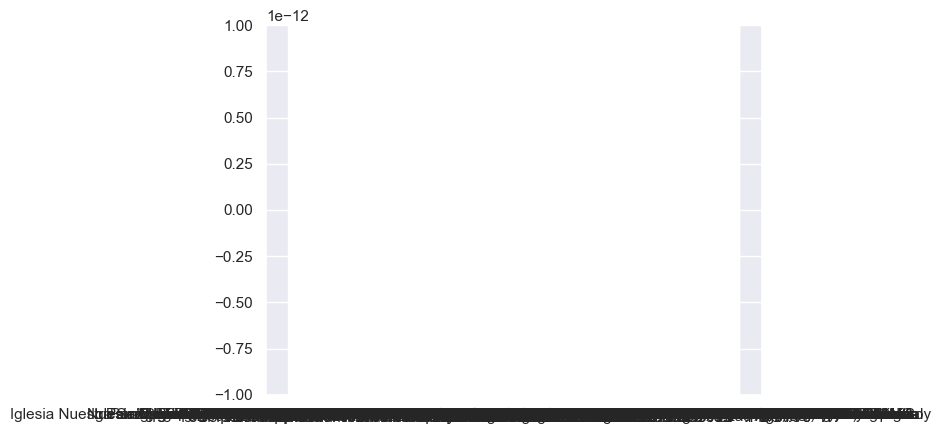

In [47]:
plt.plot(merge()['Place of interest'], merge()['Distance'])
plt.show()

In [10]:
def min_distance():
    x = str(input('Introduce un sitio: '))
    y = merge()[merge()['Place of interest']== x]
    return y.sort_values(by='Distance', ascending=True).head(1).drop(['City', 'lat_start', 'long_start', 'start', 'geometry_coordinates', 'long_finish', 'lat_finish', 'final'], axis = 1)


In [11]:
min_distance()

Introduce un sitio: Comunidad Evangélica Internacional


,Place of interest,Place address,Type of place,BiciMAD station,Station location,Distance
108190,Comunidad Evangélica Internacional,CALLE CIDRO 14 PLANTA BAJO Polígono Aguacate,no_catolicas,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,4871.244235


In [49]:
def all_min_stations():
    return merge().sort_values(by = "Distance", ascending = True).groupby('Place of interest')['Type of place','Place address','BiciMAD station', 'Station location','Distance'].nth(0)


In [50]:
all_min_stations()

/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Type of place,Place address,BiciMAD station,Station location,Distance
Place of interest,,,,,
Asambleas de Evangelización Mundial para Cristo (AEMC),no_catolicas,CALLE ANTONIA RODRIGUEZ SACRISTAN 8,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,4256.791685
Asociación Darse - Dar Ayuda para la Reinserción Social España,no_catolicas,CAMINO ALTO DE SAN ISIDRO 16 PLANTA 2º C C,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,721.784455
Asociación Tiempo Para Cuidar,no_catolicas,CALLE GENERAL LACY 24 PLANTA BAJA A,Delicias,Calle Bustamante nº 1,393.104787
Asociación Visión Internacional,no_catolicas,CALLE DISCOBOLO 53,Gutierre de Cetina,Calle Gutierre de Cetina nº 77,3444.260438
Basílica Jesús de Medinaceli,catolicas,PLAZA JESUS 2,Huertas,Calle Jesús nº 1,82.222184
...,...,...,...,...,...
Testigos Cristianos de Jehová. Calle Puerto de Pozazal,no_catolicas,CALLE PUERTO DE POZAZAL 1 PLANTA BAJA,Pavones,Calle Hacienda de Pavones nº 342,2412.389203
Testigos Cristianos de Jehová. Calle San Moisés,no_catolicas,CALLE SAN MOISÉS 39 PLANTA BAJA B,Concordia,Calle Arroyo del Olivar nº 6,1308.834521
Testigos Cristianos de Jehová. Calle Tembleque,no_catolicas,CALLE TEMBLEQUE 64 PLANTA BAJA,Caramuel,Calle Caramuel nº 51,3869.020605


In [56]:
all_min_stations().to_csv('prueba.csv')

/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/Users/jorgediazserrano/miniconda3/envs/proyecto1/lib/python3.7/site-packages/matplotlib/axes/_base.py:2919: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


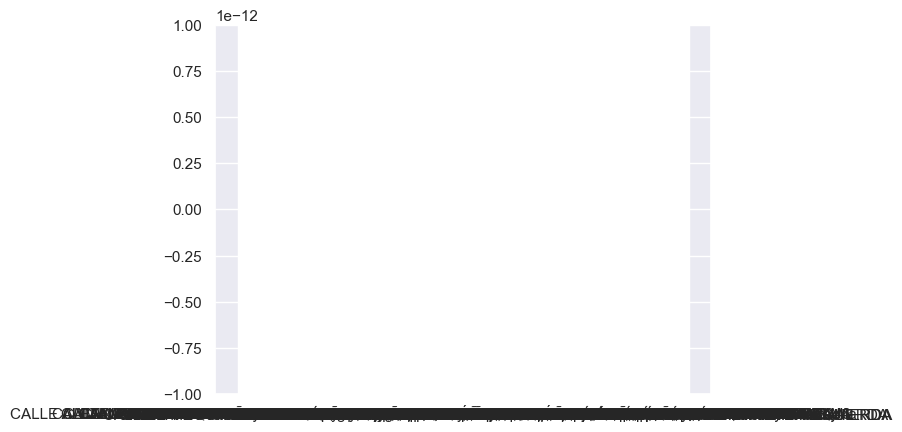

In [54]:
plt.plot(all_min_stations()['Place address'], all_min_stations()['Distance'])
plt.show(5)

In [58]:
df_prueba = pd.read_csv('prueba.csv')
df_prueba

,Place of interest,Type of place,Place address,BiciMAD station,Station location,Distance
0,Asambleas de Evangelización Mundial para Crist...,no_catolicas,CALLE ANTONIA RODRIGUEZ SACRISTAN 8,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,4256.791685
1,Asociación Darse - Dar Ayuda para la Reinserci...,no_catolicas,CAMINO ALTO DE SAN ISIDRO 16 PLANTA 2º C C,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,721.784455
2,Asociación Tiempo Para Cuidar,no_catolicas,CALLE GENERAL LACY 24 PLANTA BAJA A,Delicias,Calle Bustamante nº 1,393.104787
3,Asociación Visión Internacional,no_catolicas,CALLE DISCOBOLO 53,Gutierre de Cetina,Calle Gutierre de Cetina nº 77,3444.260438
4,Basílica Jesús de Medinaceli,catolicas,PLAZA JESUS 2,Huertas,Calle Jesús nº 1,82.222184
...,...,...,...,...,...,...
529,Testigos Cristianos de Jehová. Calle Puerto de...,no_catolicas,CALLE PUERTO DE POZAZAL 1 PLANTA BAJA,Pavones,Calle Hacienda de Pavones nº 342,2412.389203
530,Testigos Cristianos de Jehová. Calle San Moisés,no_catolicas,CALLE SAN MOISÉS 39 PLANTA BAJA B,Concordia,Calle Arroyo del Olivar nº 6,1308.834521
531,Testigos Cristianos de Jehová. Calle Tembleque,no_catolicas,CALLE TEMBLEQUE 64 PLANTA BAJA,Caramuel,Calle Caramuel nº 51,3869.020605
532,Testigos Cristianos de Jehová. Calle Venancio ...,no_catolicas,CALLE VENANCIO MARTIN 19 local 2,Sierra Toledana,Camino de Valderribas nº 94,140.927169


In [115]:
df_prueba3 = pd.read_csv('prueba.csv')


,Unnamed: 0,Place of interest,Type of place,Place address,BiciMAD station,Station location,Distance
0,0,Asambleas de Evangelización Mundial para Crist...,no_catolicas,CALLE ANTONIA RODRIGUEZ SACRISTAN 8,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,4256.791685
1,1,Asociación Darse - Dar Ayuda para la Reinserci...,no_catolicas,CAMINO ALTO DE SAN ISIDRO 16 PLANTA 2º C C,Marqués de Vadillo,Glorieta Marqués de Vadillo nº 9,721.784455
2,2,Asociación Tiempo Para Cuidar,no_catolicas,CALLE GENERAL LACY 24 PLANTA BAJA A,Delicias,Calle Bustamante nº 1,393.104787
3,3,Asociación Visión Internacional,no_catolicas,CALLE DISCOBOLO 53,Gutierre de Cetina,Calle Gutierre de Cetina nº 77,3444.260438
4,4,Basílica Jesús de Medinaceli,catolicas,PLAZA JESUS 2,Huertas,Calle Jesús nº 1,82.222184


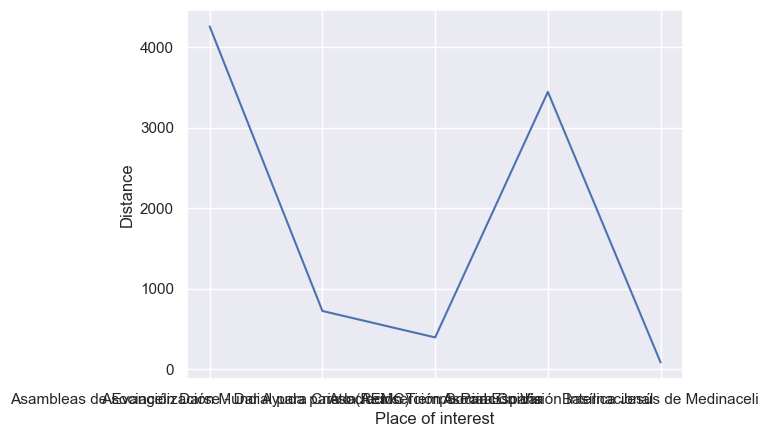

In [120]:
df_prueba2 = sns.lineplot(x="Place of interest", y="Distance", data=df_prueba3)
df_prueba2
plt.show()

In [81]:
df_prueba2

<AxesSubplot:xlabel='Place of interest', ylabel='Distance'>

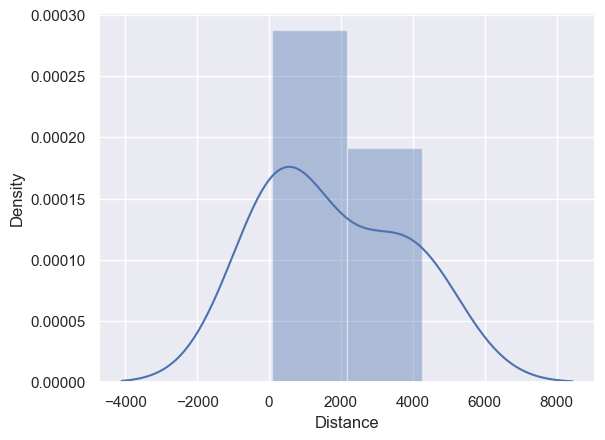

In [107]:
#sns.distplot(df_prueba1['Place of interest'])
sns.distplot(df_prueba1['Distance'])
plt.show()

### sns.factorplot(x ='Place of interest', y ='Distance', data = df_prueba1) 
  
plt.show() 